# RSNA_Pneumonia_v001

* v001: Initial Commit

## Imports

https://pydicom.github.io/pydicom/dev/getting_started.html

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import uuid
import pydicom
import glob, pylab
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
import math
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from os.path import join
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['dcm_data.csv', 'stage_1_detailed_class_info.csv', 'stage_1_sample_submission.csv', 'stage_1_train_labels.csv']


## Constants & Functions

Constants

In [2]:
PATH= '../input'#/rsna-pneumonia-detection-challenge/'
path_pics = r'C:\Users\Lorenzo\Downloads\stage_1_train_images'#join(PATH,'stage_1_train_images')

Functions

In [3]:
class Box():
    
    def __init__(self, y, x, h, w):
        self.y, self.x, self.h, self.w = y, x, h, w

def row2string(row):
    """
    row box to string [y, x, height, width]
    """
    if row is None:
        return ''
    elif math.isnan(row['y']):
        return ''
    else:
        return '{0}_{1}_{2}_{3}'.format(row['y'], row['x'], row['height'], row['width'])
    
def string2boxes(s):
    """
    strings to boxes [y, x, height, width]
    """
    if s == None:
        raise ArgumentException()
    elif s == '' or s == '#':
        return None
    
    boxes = []
    ss = s.split('#')
    for r in ss:
        rr = r.split('_')
        try:
            box = Box(float(rr[0]), float(rr[1]), float(rr[2]), float(rr[3]))
            boxes.append(box)
        except:
            continue
        
    return boxes

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 
    """
    name_pic = data['patientId'] + '.dcm'
    fullpath_pic = join(path_pics, name_pic)

    # --- Open DICOM file
    d = pydicom.read_file(fullpath_pic)
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    boxes = string2boxes(data['boxes'])
    
    # print data
    print(d)
    
    if(boxes != None):
        for box in boxes:
#             rgb = np.floor(np.random.rand(3) * 256).astype('int')
            im = overlay_box(im=im, box=box, rgb=[255, 0, 0], stroke=6)

    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap=pylab.cm.gist_gray)

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image
    """
    
    # --- Extract coordinates
    y1, x1, height, width = int(box.y), int(box.x), int(box.h), int(box.w)
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [4]:
train_label = pd.read_csv(join(PATH,'stage_1_train_labels.csv'))
detailed_class = pd.read_csv(join(PATH,'stage_1_detailed_class_info.csv'))

In [5]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28989 entries, 0 to 28988
Data columns (total 6 columns):
patientId    28989 non-null object
x            8964 non-null float64
y            8964 non-null float64
width        8964 non-null float64
height       8964 non-null float64
Target       28989 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.3+ MB


Build complete DataFrame
* Make a single string out of all the boxes relative to a single patient
* Add pic's properties to df

In [6]:
df = pd.merge(train_label, detailed_class, on='patientId')
df = pd.concat([df, pd.get_dummies(df['class'])], axis=1)

Execute the following code if generating the db

In [7]:
name_pic = pd.read_csv(join(PATH,'dcm_data.csv'), index_col=0)
name_pic['Age'] = name_pic['Age'].astype(int)
name_pic.head()

,Age,Sex,View Position,boxes,patientId
0,51,F,PA,#,0004cfab-14fd-4e49-80ba-63a80b6bddd6
1,48,F,PA,#,00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2,19,M,AP,#,00322d4d-1c29-4943-afc9-b6754be640eb
3,28,M,PA,#,003d8fa0-6bf1-40ed-b54c-ac657f8495c5
4,32,F,AP,NaN,00436515-870c-4b36-a041-de91049b9ab4


In [8]:
df = pd.concat([df, name_pic.drop('patientId', axis=1)], axis=1)
df = df.drop(['x', 'y', 'width', 'height'], axis=1)
df = df.dropna(axis=0, subset=['boxes'])
df.head()

,patientId,Target,class,Lung Opacity,No Lung Opacity / Not Normal,Normal,Age,Sex,View Position,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,0,1,0,51,F,PA,#
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,No Lung Opacity / Not Normal,0,1,0,48,F,PA,#
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,No Lung Opacity / Not Normal,0,1,0,19,M,AP,#
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,Normal,0,0,1,28,M,PA,#
7,00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity,1,0,0,32,F,AP,#152.0_264.0_379.0_213.0#152.0_264.0_379.0_213...


In [9]:
len(df['patientId']) == len( set(df['patientId']))

True

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.21004.1517874431.100900
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00c0b293-48e7-4e16-ac76-9269ba535a62'
(0010, 0020) Patient ID                          LO: '00c0b293-48e7-4e16-ac76-9269ba535a62'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

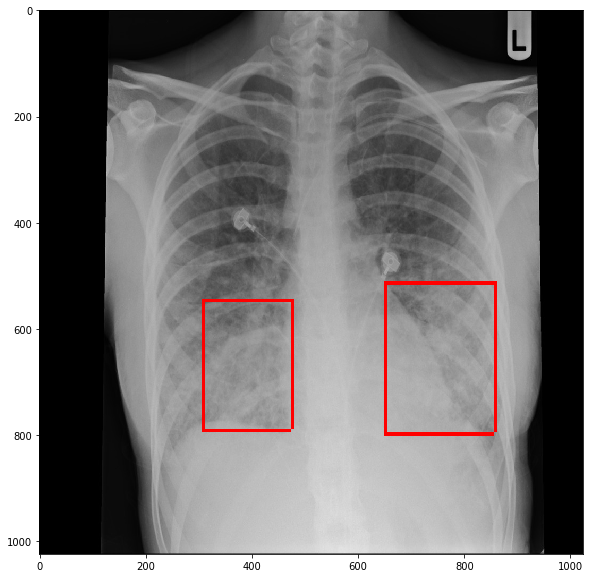

In [10]:
draw(df.iloc[13])

## Analysis

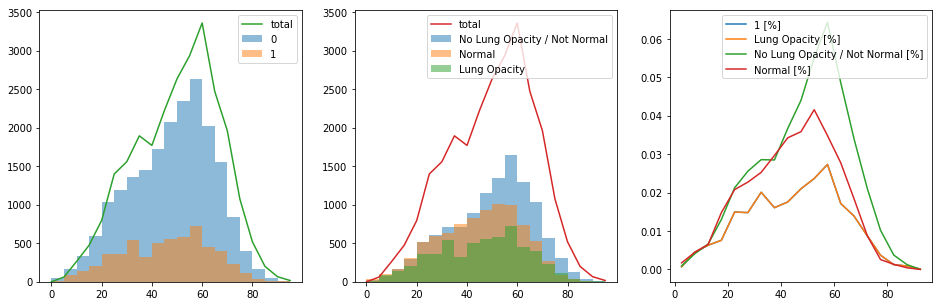

In [11]:
bins = range(0,100,5)
plt.figure(figsize=(16,5))

#plt.figure(1)
plt.subplot(1,3,1)
age_1 = df[['Age', 'Target']][df['Target'] ==1]
age_0 = df[['Age', 'Target']][df['Target'] ==0]

a, _, _ = plt.hist(age_0.sort_values('Age')['Age'], bins, alpha=0.5, label='0')
b, _, _ = plt.hist(age_1.sort_values('Age')['Age'], bins, alpha=0.5, label='1')
plt.plot(range(0,100,5),[0]+[a+b for a,b in zip(*[a,b])], label='total')
plt.legend()


plt.subplot(1,3,2)
lung_opac = df[['Age', 'Target']][df['Lung Opacity'] ==1]
lung_boh = df[['Age', 'Target']][df['No Lung Opacity / Not Normal'] ==1] 
lung_norm = df[['Age', 'Target']][df['Normal'] ==1]

a, _, _ = plt.hist(lung_boh.sort_values('Age')['Age'], bins, alpha=0.5, label='No Lung Opacity / Not Normal')
b, _, _ = plt.hist(lung_norm.sort_values('Age')['Age'], bins, alpha=0.5, label='Normal')
c, _, _ = plt.hist(lung_opac.sort_values('Age')['Age'], bins, alpha=0.5, label='Lung Opacity')
plt.plot(range(0,100,5),[0]+[a+b+c for a,b,c in zip(*[a,b,c])], label='total')
plt.legend()


plt.subplot(1,3,3)
g = pd.cut(df.sort_values('Age')['Age'], bins)
g = df.groupby(g, sort=False)
g_t = g['Target'].aggregate('sum') / len(df)
g_opac = g['Lung Opacity'].aggregate('sum') / len(df)
g_boh = g['No Lung Opacity / Not Normal'].aggregate('sum') / len(df)
g_norm = g['Normal'].aggregate('sum') / len(df)

plt.plot([x.mid for x in g_t.index], g_t, label='1 [%]')
plt.plot([x.mid for x in g_t.index], g_opac, label='Lung Opacity [%]')
plt.plot([x.mid for x in g_t.index], g_boh , label='No Lung Opacity / Not Normal [%]')
plt.plot([x.mid for x in g_t.index], g_norm, label='Normal [%]')
#plt.plot([(a,b) for a,b in zip(*[g_norm.values, g_boh.values])])

plt.legend()
plt.show()

## Correlations